In [312]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.uniform([.1,.2,])

array([0.96829649, 0.8328914 ])

In [347]:
np.array([1,2]) is None
del x

In [761]:

import collections
def state2dist(x,state_space = None):
    '''
    x is a list of states to be converted into a distribution
    '''
    if state_space is None:
        state_space = max(x)+1
    if isinstance(x,np.ndarray):
        x = x.tolist()
    ct = collections.Counter(x)
#    ct.update()
    lst = [0]*state_space
    for k,v in ct.items():
        lst[k] = v
    final_dist = np.array(lst,dtype='float')
    final_dist = final_dist/final_dist.sum()
#    print final_dist
    return final_dist
print state2dist(np.random.randint(0,5,100))



def check_transition(mat,epsilon = 1E-10):
    print mat
    assert np.all(abs(mat.sum(axis = 1) - 1) < epsilon)
    
    

def find_stationary(b):
    w,v = np.linalg.eig(b.T)
    lv = v.T
    same_sign = (lv > 0).all(axis = 1) | (lv < 0).all(axis = 1)
    stat_idx, = np.where( same_sign & (w > 0 ))
    stat_vct = lv.take(stat_idx,axis = 0)
    stat_vct = stat_vct / stat_vct.sum()
    return stat_vct



######## We start with a discrete version of hmm
class Var_hmm(object):
    def __init__(self, 
                 transition = np.array([[0.1,.9],[.2,.8]]),
                 emission_mat = np.array([[.5, .4, .1, 0],[0, .1, .4, .5]]),
                 internal_initial = np.array([[.8, .2]]),
                 t = -1, 
                 internal_list = None,
                 emission_list =['0','1','2','3']):
        if internal_list is None:
            if hasattr(internal_initial,'size'):
                N = internal_initial.size
            else:
                N = len(internal_initial)
            internal_list = list(range(N))
        internal_initial = np.array(internal_initial)
        self.transition = np.array(transition)
        self.internal_initial = np.array(internal_initial)
#        self.internal_dict = 
        self.internal_list = internal_list
        self.emission_list = emission_list
        assert len( internal_list ) == internal_initial.size
        self.emission_mat = emission_mat
        self.internal_space= len(internal_list)
        self.emission_space = len(emission_list)
        self.t = t
        self.internal = None
        self.emssion  = None
#        self.sample()
        pass    
    def sample(self, as_idx = False,
               debug = False,**kwargs):
        if self.t == -1:
#        if self.internal is None:
            distrib = self.internal_initial
        else:
            distrib = self.transition[self.internal,:]
        distrib = distrib.ravel()
        if debug:
            print distrib
        
        internal = np.random.choice( self.internal_space, size = 1, p = distrib)[0]
        self.internal = internal
        self.t += 1
        if not as_idx:
            internal = self.internal_list[internal]
        return internal
    def run_for(self, T = 10,debug = False,**kwargs):
#        chain = [ self.sample() for i in range(T)]
 #       return chain 
  #      chain = [None]*T
        chain = np.zeros([T],dtype=int)
        
        for i in range(T):
            chain[i] = self.sample(debug = debug ,**kwargs)
#            chain[i] += [h1.sample()]
        return(chain)

    def _emit(self, internal, as_idx = False):
        distrib = self.emission_mat[ internal,:]
        distrib = distrib.ravel()
        emission = np.random.choice( self.emission_space, size = 1, p = distrib)[0]
        if not as_idx:
            emission = self.emission_list[emission]
        return emission
        
    def emit(self, as_idx = False):
        emission = self._emit(self.internal, as_idx = as_idx)
        self.emission = emission
        return self.emission
    def bulk_emit(self,chain,as_idx = False):
        echain = map(functools.partial(self._emit, as_idx = as_idx), 
                     chain)
        return echain
    
    def find_stationary(self):
        return find_stationary(self.transition)
    def reset(self, t = -1 ):
        self.t = t
        
def cross_entropy(y, t, epsilon = 1E-16):
    return - np.sum( t * np.log(y+epsilon) - t * np.log(t+epsilon),axis = -1)

def MAE(y,t):
    return abs(y - t).sum(axis = -1)

h1 = Var_hmm()
ch = h1.run_for(50)
#ch = h1.run_for(100,debug = 1)
print h1.emit()
print  ch 
print h1.find_stationary()

print "Done"

[0.23 0.17 0.19 0.21 0.2 ]
3
[0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1
 1 1 0 1 1 1 0 1 0 1 1 1 1]
[[0.18181818 0.81818182]]
Done


[[9.12734720e-01 1.92589122e-02 2.28446010e-02 2.12131005e-02
  2.34953277e-02 4.53339041e-04]
 [2.54997943e-04 9.08719800e-01 1.14308037e-02 5.13973160e-03
  1.04982137e-02 6.39564530e-02]
 [1.48456116e-02 7.45937169e-04 9.23168380e-01 5.01036012e-03
  4.07704439e-03 5.21526669e-02]
 [1.51498262e-02 8.31123904e-03 3.68751664e-02 9.23180168e-01
  3.75798048e-03 1.27256194e-02]
 [3.32787648e-03 1.18662795e-02 3.94362637e-02 4.23071199e-02
  8.72111199e-01 3.09512613e-02]
 [6.70408478e-02 6.87678019e-03 1.05605635e-02 1.16870402e-01
  9.97311722e-02 6.98920234e-01]]
[1. 1. 1. 1. 1. 1.]
(100,)


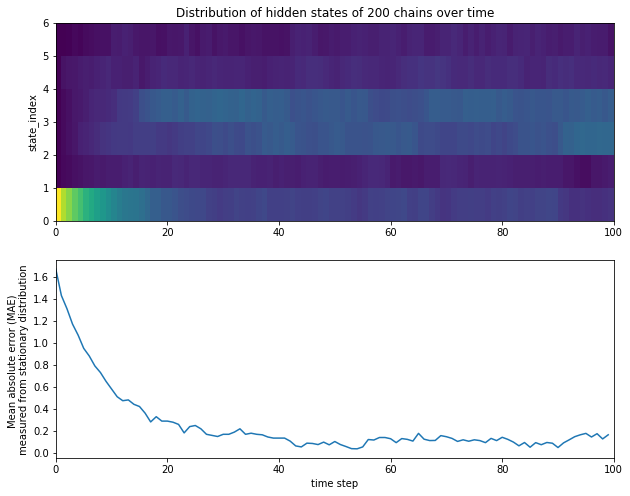

In [748]:
##### A test case that highlights the relaxation of a markov chain

N = 6
##### Init a random transition matrix
trans_mat = np.random.exponential(size = (N,N)) 
#trans_mat = np.random.random(size = (N,N)) 
trans_mat += np.diag( np.diag(trans_mat) +  10*np.arange(N,0,-1)) ### strength the diagonal terms to extend mixing time
trans_mat /= trans_mat.sum(axis = 1,keepdims=1)
check_transition(trans_mat)
print trans_mat.sum(axis=1)

##### Use delta function as initial distribution
ini = [1.]+[0.]*(N-1)

N_chain = 200
lst = [Var_hmm(transition=trans_mat,
               internal_initial= ini,
               internal_list=range(N)) for i in range(N_chain)]
#assert 0 ==1
def f(x):
    #h1 = Var_hmm()
    ch = x.run_for(100)
    return ch
chains = np.array(map(f,lst))


h1 = lst[0]
import functools
f = functools.partial(state2dist,state_space = h1.internal_space)
ds = np.vstack(map(f,chains.T))

#loss = cross_entropy( ds, h1.find_stationary())
loss = MAE( ds, h1.find_stationary())
# loss = abs(loss).sum(axis = 1)
print loss.shape
# plt.plot(loss)
fig = plt.figure(figsize= [10,8])
ax = fig.add_subplot(211)
ax.pcolormesh(ds.T)
plt.ylabel('state_index')
plt.title('Distribution of hidden states of %d chains over time' % N_chain)
plt.subplot(212,sharex=ax)
#fig = plt.figure(figsize= [10,4])
plt.plot(loss)
plt.xlim(0,100)
plt.xlabel('time step')
plt.ylabel('Mean absolute error (MAE) \n measured from stationary distribution ')


In [626]:
from scipy import sparse
mat = sparse.dok_matrix()

In [646]:
[chain[i:i+2] for i in range(len(chain)-1)]

[array([0, 1]),
 array([1, 1]),
 array([1, 1]),
 array([1, 1]),
 array([1, 1]),
 array([1, 1]),
 array([1, 1]),
 array([1, 1]),
 array([1, 1]),
 array([1, 1]),
 array([1, 1]),
 array([1, 0]),
 array([0, 1]),
 array([1, 1]),
 array([1, 1]),
 array([1, 1]),
 array([1, 1]),
 array([1, 1]),
 array([1, 1]),
 array([1])]

In [713]:

chain = read_chain(text = buf)
print chain


[[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0.]]


In [728]:
####### MLE for single

def read_chain(fname=None,text = None,dtype = 'float'):
    if text is None:
        text = open(fname,'r').read()
    buf = []
    for line in text.splitlines():
        lst = line.split(',')
#        if len(lst)<=1:
        lst = [ float(x.strip()) for x in lst if x]
        if lst:
            buf.append( lst )
    c = np.array(buf,dtype = dtype)
    return  c

buf = '''
0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0
'''
chain = read_chain(text = buf,dtype = 'int')[0]

def mle_tmat_internalChain(chain, Hn = None,epsilon = 0):
    '''
    epsilon: an adjustable pesudo count
    '''
    Hn = max(chain) + 1
    trans = collections.Counter([tuple(chain[i:i+2]) for i in range(len(chain)-1)])

    mat = np.zeros((Hn,Hn))
    for k,v in trans.iteritems():
        mat[k]=float(v) + epsilon
    mat /= mat.sum(axis = 1,keepdims = 1)    
    return mat

chain = list(chain[:20])
print "Truncating chain to 20 elements:",chain 
print 'MLE for transition matrix is:\n',mle_tmat_internalChain(chain)


Truncating chain to 20 elements: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0]
MLE for transition matrix is:
[[0.         1.        ]
 [0.26666667 0.73333333]]


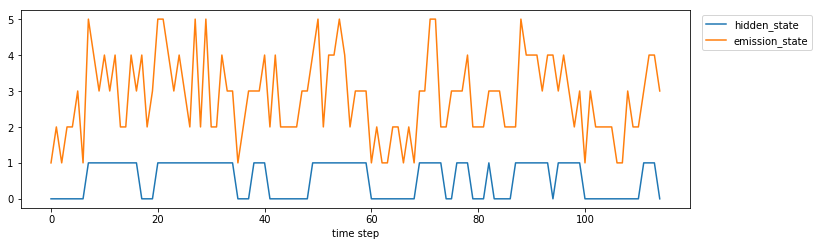

In [786]:
#### Question 3

h1 = Var_hmm(
    internal_list = [0,1],
    emission_list = [ (x) for x in [1,2,3,4,5]],
    transition = np.array([[0.8, 0.2],[0.1,0.9]]),
    emission_mat = np.array([[0.2, 0.5, 0.2, 0.1, 0],[ 0, 0.1, 0.4 ,0.4 , 0.1]])
)
n = 115
chain = h1.run_for(n,as_idx = 1)
emission_chain = h1.bulk_emit(chain)

fig = plt.figure(figsize= [12,8])
plt.subplot(211)
plt.plot(chain,label = 'hidden_state')
plt.plot(emission_chain, label ='emission_state')
plt.legend(bbox_to_anchor=(1.19, 1.00))
plt.xlabel('time step')
#h1.bulk_emit([1,1,0,0,0],as_idx = 1)



In [554]:
### Playground for numpy array

a = np.array([[1,2,3]])
#a = np.array([[1,2,3]]).T
b = np.array(range(9)).reshape([3,3])
print a.shape, b.shape
print (a.dot(b)).shape
c = a.dot(b)
print c
print a
print b
print( b[0,:])
print b.sum(axis = 0)
b.take(0)

(1, 3) (3, 3)
(1, 3)
[[24 30 36]]
[[1 2 3]]
[[0 1 2]
 [3 4 5]
 [6 7 8]]
[0 1 2]
[ 9 12 15]


0